In [1]:
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

import pandas as pd
from numpy import mean, std
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
path = r"PGR_Dataset_1\training_sets\LL - RunLabSagittal Plane Left_Sagittal Plane Right_Posterior Frontal Planetraining_set.csv"
df = pd.read_csv(path)

#get rid of error frames b/c they do not reflect reality
df_no_error = df[df.iloc[:, -1] != 'error']
print(df_no_error)

       pfWaist  pfLeftFemurHead  pfLeftKnee  pfLeftAnkle  pfRightFemurHead  \
0     1.000000         0.851468    0.209713     0.070856          0.286127   
1     0.600346         1.000000    0.250331     0.253342          0.514451   
2     0.536332         0.972366    0.233113     0.008690          0.413295   
3     0.415225         0.979275    0.231347     0.010695          0.242775   
4     0.422145         0.891192    0.185430     0.215909          0.078035   
...        ...              ...         ...          ...               ...   
2695  0.136939              NaN         NaN          NaN          0.752830   
2696  0.308400         0.408039         NaN          NaN          0.783962   
2697  0.242808         0.095006         NaN          NaN          0.654717   
2698  0.276180         0.209501         NaN          NaN          0.651887   
2699  0.403913         0.015834         NaN          NaN          0.585849   

      pfRightKnee  pfRightAnkle   LeftArm   LeftHip  LeftKnee  

In [3]:
df_clean = df_no_error.dropna(subset=df_no_error.columns[-1])
print(df_clean.shape)

#Remove whitespaces in column names
df_clean.columns = df_clean.columns.str.strip()
#Seperate the dependent and independent variables
y = df_clean.iloc[:, -1]
display(y)
X = df_clean.drop(df_clean.columns[-1], axis=1)
display(X)

(2682, 18)


0       Loading Response
1       Loading Response
2       Loading Response
3              Midstance
4        Terminal Stance
              ...       
2695            Midswing
2696            Midswing
2697            Midswing
2698            Midswing
2699            Midswing
Name: LL - RunLab, Length: 2682, dtype: object

,pfWaist,pfLeftFemurHead,pfLeftKnee,pfLeftAnkle,pfRightFemurHead,pfRightKnee,pfRightAnkle,LeftArm,LeftHip,LeftKnee,LeftAnkle,LeftToe,RightArm,RightHip,RightKnee,RightAnkle,RightToe
0,1.000000,0.851468,0.209713,0.070856,0.286127,0.044564,0.093202,0.664400,0.331073,0.739330,0.178694,0.055060,0.363715,0.413294,0.140407,0.616275,0.254627
1,0.600346,1.000000,0.250331,0.253342,0.514451,0.027919,0.193479,0.574708,0.367781,0.706517,0.095411,0.016582,0.423442,0.300595,0.085443,0.558044,0.345672
2,0.536332,0.972366,0.233113,0.008690,0.413295,0.011275,0.021532,0.504145,0.385317,0.676342,0.026076,0.000213,0.489211,0.222222,0.065916,0.558791,0.489851
3,0.415225,0.979275,0.231347,0.010695,0.242775,0.012617,0.003691,0.387673,0.477437,0.715122,0.020821,0.071429,0.553772,0.138492,0.063023,0.615901,0.568955
4,0.422145,0.891192,0.185430,0.215909,0.078035,0.005101,0.015072,0.327311,0.560907,0.758949,0.025268,0.133929,0.592784,0.087500,0.084203,0.430758,0.025075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.136939,NaN,NaN,NaN,0.752830,0.243632,0.093674,0.310796,0.579277,0.940580,0.917808,0.292044,0.264996,0.548474,0.682741,0.081912,0.048295
2696,0.308400,0.408039,NaN,NaN,0.783962,0.223145,0.152593,0.376383,0.509157,0.964108,0.881507,0.270896,0.216167,0.589064,0.703318,0.072454,0.081806
2697,0.242808,0.095006,NaN,NaN,0.654717,0.112957,0.106163,0.443839,0.438706,0.980636,0.782877,0.072508,NaN,0.576988,0.707125,0.056072,0.110191
2698,0.276180,0.209501,NaN,NaN,0.651887,0.110742,0.050502,0.519863,0.383435,0.037487,0.736301,0.037261,0.028347,0.607514,0.717277,0.056240,0.098955


In [4]:
# Confirm oversampling effect
counter = Counter(y)
for key, value in counter.items():
    per = value / len(y) * 100
    print('Class=%s, n=%d (%.2f%%)' % (key, value, per))

Class=Loading Response, n=387 (14.43%)
Class=Midstance, n=66 (2.46%)
Class=Terminal Stance, n=550 (20.51%)
Class=Toe Off, n=65 (2.42%)
Class=Initial Swing, n=174 (6.49%)
Class=Midswing, n=1272 (47.43%)
Class=Terminal Swing, n=103 (3.84%)
Class=Initial Strike, n=65 (2.42%)


In [5]:
#Numerically encode the target variables
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

#Use a knn imputer to fill in blanks in the data
knn_imputer = KNNImputer(n_neighbors=5)
#fit it to the data
knn_imputer.fit(X_train)
X_train = knn_imputer.transform(X_train)
X_test = knn_imputer.transform(X_test)

# Perform Synthetic Minority Oversampling TEchnique in order to synthetically balance the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

# Confirm oversampling effect
counter = Counter(y_train)
for key, value in counter.items():
    per = value / len(y_train) * 100
    print('Class=%s, n=%d (%.2f%%)' % (key, value, per))

Class=4, n=1132 (12.50%)
Class=1, n=1132 (12.50%)
Class=2, n=1132 (12.50%)
Class=5, n=1132 (12.50%)
Class=3, n=1132 (12.50%)
Class=7, n=1132 (12.50%)
Class=0, n=1132 (12.50%)
Class=6, n=1132 (12.50%)


In [6]:
models = {
    #Ensemble Models
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100),
}

k-Fold Cross Validation for Random Forest = Mean Accuracy: 0.983 (std: 0.005)
Overall F1 Score: 0.874
              precision    recall  f1-score   support

           0       0.38      0.71      0.50         7
           1       0.75      0.88      0.81        17
           2       0.94      0.83      0.88        41
           3       0.30      0.50      0.37         6
           4       0.99      0.95      0.97       140
           5       0.95      0.86      0.90        44
           6       0.50      0.67      0.57         9
           7       0.25      0.20      0.22         5

    accuracy                           0.87       269
   macro avg       0.63      0.70      0.65       269
weighted avg       0.90      0.87      0.88       269

k-Fold Cross Validation for Extra Trees = Mean Accuracy: 0.988 (std: 0.004)
Overall F1 Score: 0.881
              precision    recall  f1-score   support

           0       0.40      0.57      0.47         7
           1       0.76      0.94     

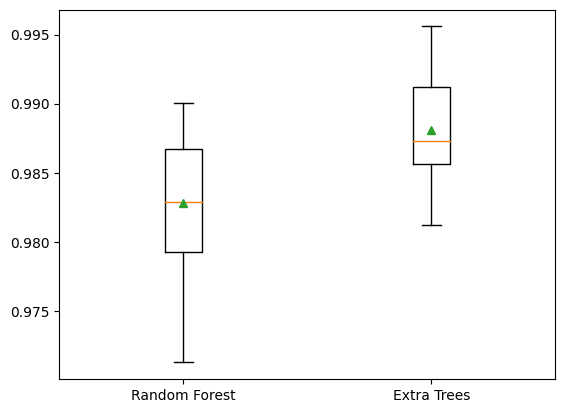

In [7]:
def test_models(X_trn, y_trn, X_tst, model):
    #k-fold seperates the data into 10 randomly selected groups and automatically splits these into test and train groups
    #this is repeated 3 times and the mean accuracy is reported
    #Note: this is done on data after I already split it 90/10. I did this so that I could confidently use F1 scoring and a classification report later
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=117)
    scores = cross_val_score(model, X_trn, y_trn, scoring='accuracy', cv=cv, n_jobs=-1)
    fit = model.fit(X_trn, y_trn)
    predict = model.predict(X_tst)
    return scores, fit, predict

# evaluate each model
results = []
names = []
for i in models:
    # evaluate the model and store results
    scores, fit, predict = test_models(X_train, y_train, X_test, models[i])
    results.append(scores)
    names.append(i)
    # summarize performance
    print('k-Fold Cross Validation for %s = Mean Accuracy: %.3f (std: %.3f)' % (i, mean(scores), std(scores)))
    print('Overall F1 Score: ' + str(round(f1_score(y_test, predict, average='micro'), 3)))
    print(classification_report(y_test, predict))

plt.boxplot(results, labels=names, showmeans=True)
plt.show()